In [2]:
import pickle
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.frame import DataFrame

In [3]:
group_id = "dbpedia_14_20240102_self_check"

# load result
result_files = glob.glob(f"./results/{group_id}/*.pickle")
results = []
for file in result_files:
    with open(file, "rb") as f:
        results.append(pickle.load(f))

# create plots folder
os.makedirs(f"./plots/{group_id}/", exist_ok=True)

In [8]:
# make results into dataframe
df_columns = ["model", "label", "accuracy", "precision", "TP", "TN", "FP", "FN", "n_samples", "n_trials", "strategy"]
df_data = []
time_elapsed = 0
ex_id = ""
args = {}
for r in results:
    # when different args, display it
    if args != r["args"]:
        print("#data: ", len(df_data))
        print("experiment settings: ", r["args"])
    args = r["args"]
    n_trials = args.n_trials
    max_retry = args.max_retry
    model = args.model
    strategy = args.strategy
    for trial in r["result"]:
        for sample in trial:
            df_data.append([
                model,
                sample["class label"],
                sample["accuracy"],
                sample["precision"],
                sample["TP"],
                sample["TN"],
                sample["FP"],
                sample["FN"],
                sample["n_samples"],
                n_trials,
                strategy,
            ])
    time_elapsed = int(r["finish_time"]) - int(r["start_time"])
    ex_id = r["experiment_id"]
df_results = pd.DataFrame(df_data, columns=df_columns)
print("---")
print("time elapsed: ", time_elapsed)
print("experiment id: ", ex_id)
print("#data: ", len(df_data))
print(df_results.loc[0:14].to_latex(escape=True))

#data:  0
experiment settings:  Namespace(group_id='dbpedia_14_20240102_self_check', n_trials=10, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo', logging=True, max_retry=3, test=False, strategy='normal', verification='themselves')
#data:  588
experiment settings:  Namespace(group_id='dbpedia_14_20240102_self_check', n_trials=10, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo', logging=True, max_retry=3, test=False, strategy='super', verification='themselves')
---
time elapsed:  137780
experiment id:  b0da15284fadf420f4eb9fe15eac0f5e
#data:  1150
\begin{tabular}{lllrrrrrrrrl}
\toprule
 & model & label & accuracy & precision & TP & TN & FP & FN & n\_samples & n\_trials & strategy \\
\midrule
0 & gpt-3.5-turbo & Company & 0.800000 & 0.600000 & 3 & 5 & 2 & 0 & 5 & 10 & normal \\
1 & gpt-3.5-turbo & EducationalInstitution & 0.900000 & 1.000000 & 5 & 4 & 0 & 1 & 5 & 10 & normal \\
2 & gpt-3.5-turbo & Artist & 1.000000 & 1.000000 & 5 & 5 & 0 & 

In [4]:
# group by n_sample
# res_g_sample = df_results.groupby(by=["strategy", "n_samples", "label"], as_index=False)
# res_g_sample

In [64]:
# plot accuracy and precision with df_results
# x axis: label
# y axis: accuracy/precision (average of all trials)
# group by n_sample

def plot_acc_prec_by_verification(df: DataFrame, verification="dataset", fontsize=12):
    # df_target = df.groupby(by=["strategy", "n_samples", "label"], as_index=False)
    df_target = df
    # plot
    plt.figure(figsize=(16, 8))
    # plt.title(f"{model} - dbpedia_14 dataset - {group_id}")
    # plt.xlabel("n_samples")
    # plt.ylim(0, 1)

    sub_acc = plt.subplot(1, 2, 1)
    sub_acc.set_title("accuracy", fontsize=fontsize)
    sub_acc.set_xlabel("n_samples", fontsize=fontsize)
    sub_acc.set_ylabel("accuracy", fontsize=fontsize)
    sub_acc.set_ylim(0.45, 1.05)
    
    sub_prec = plt.subplot(1, 2, 2)
    sub_prec.set_title("precision", fontsize=fontsize)
    sub_prec.set_xlabel("n_samples", fontsize=fontsize)
    sub_prec.set_ylabel("precision", fontsize=fontsize)
    sub_prec.set_ylim(0.45, 1.05)
    
    labels = []
    # get average of accuracy and precision for each label group by n_sample
    for l, klass in df_target.groupby(by="label"):
        precs_by_n_sample = []
        accs_by_n_sample = []
        n_list = []
        for n_sample, data in klass.groupby(by="n_samples"):
            n_list.append(n_sample)
            precs_by_n_sample.append(data["precision"].mean())
            accs_by_n_sample.append(data["accuracy"].mean())
        sub_prec.plot(n_list, precs_by_n_sample, label=l)
        sub_acc.plot(n_list, accs_by_n_sample, label=l)
        plt.xticks(n_list)
        labels.append(l)
    plt.legend(labels, loc="upper right", bbox_to_anchor=(1, -0.1), ncol=5, fontsize=fontsize)
    
    # save images
    plt.savefig(f"./plots/{group_id}/dbpedia_14_{ex_id}.png")


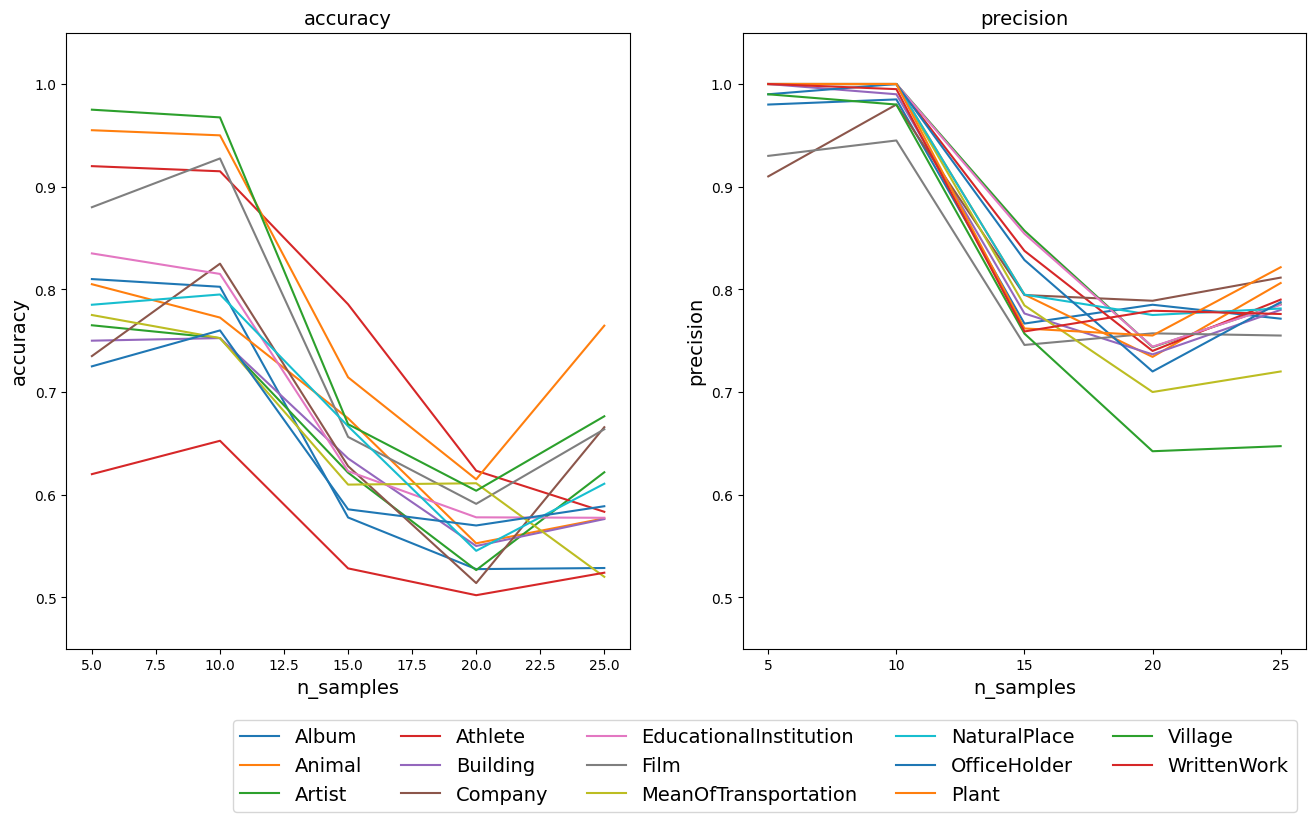

In [65]:
plot_acc_prec_by_verification(df_results, fontsize=14)